## Imports

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.utils import plot_model

import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 512
num_classes = 10
img_rows, img_cols = 28, 28

Using TensorFlow backend.


## Load data

In [2]:
X_train, y_train, X_train_skel_features = None, None, None
with open("data/train_info", "rb") as fin:
    data = pickle.load(fin)
    X_train, y_train, X_train_skel_features = data["data"], data["labels"], data["skel_features"]

X_test, y_test, X_test_skel_features = None, None, None
with open("data/test_info", "rb") as fin:
    data = pickle.load(fin)
    X_test, y_test, X_test_skel_features = data["data"], data["labels"], data["skel_features"]    

## Create data for network

In [3]:
x_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
x_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Create f1 score

In [4]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Generate model

In [5]:
model = Sequential()
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Create callbacks

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('model_cnn.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, patience=3, verbose=1)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

callbacks=[early_stopping, model_checkpoint, reduce_lr, tbCallBack]

## Fit model

In [7]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10000,
          callbacks=callbacks,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10000
60000/60000 [==============================] - 4s 62us/step - loss: 0.4228 - acc: 0.8715 - f1: 0.8493 - val_loss: 0.0999 - val_acc: 0.9693 - val_f1: 0.9699

Epoch 00001: val_loss improved from inf to 0.09993, saving model to model_cnn.h5
Epoch 2/10000
60000/60000 [==============================] - 2s 37us/step - loss: 0.1322 - acc: 0.9607 - f1: 0.9606 - val_loss: 0.0669 - val_acc: 0.9790 - val_f1: 0.9795

Epoch 00002: val_loss improved from 0.09993 to 0.06689, saving model to model_cnn.h5
Epoch 3/10000
60000/60000 [==============================] - 2s 37us/step - loss: 0.0964 - acc: 0.9705 - f1: 0.9709 - val_loss: 0.0520 - val_acc: 0.9831 - val_f1: 0.9836

Epoch 00003: val_loss improved from 0.06689 to 0.05203, saving model to model_cnn.h5
Epoch 4/10000
60000/60000 [==============================] - 2s 37us/step - loss: 0.0802 - acc: 0.9746 - f1: 0.9749 - val_loss: 0.0486 - val_acc: 0.9847 - val_f1: 0.9849

Epoch 00004: va

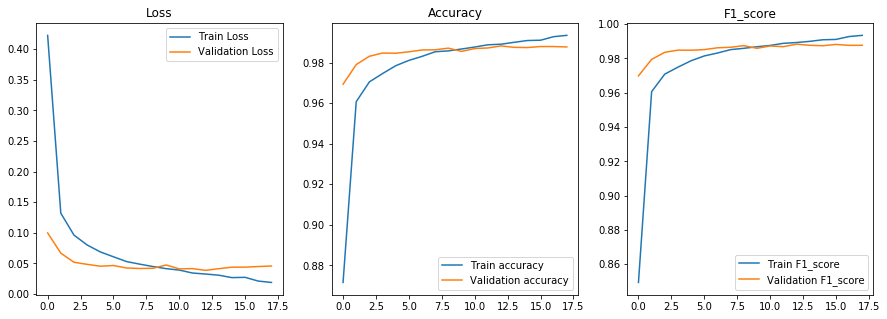

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_title('Loss')
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss")
ax[1].set_title('Accuracy')
ax[1].plot(history.epoch, history.history["acc"], label="Train accuracy")
ax[1].plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax[2].set_title('F1_score')
ax[2].plot(history.epoch, history.history["f1"], label="Train F1_score")
ax[2].plot(history.epoch, history.history["val_f1"], label="Validation F1_score")
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Score model

In [9]:
model = load_model('model_cnn.h5', custom_objects={'f1': f1})
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test f1_score:', score[2])

Test loss: 0.03878547941138131
Test accuracy: 0.9882
Test f1_score: 0.9883190298080444
